# AntiSplodge tutorial - Deconvoluted the adult mouse brain

In this tutorial we are gonna demonstrate how to deconvolute the spatial transcriptomics (ST) spots of the adult mouse brain ([10X Adult Mouse Brain](https://support.10xgenomics.com/spatial-gene-expression/datasets/1.1.0/V1_Adult_Mouse_Brain)) utilizing scRNA profiles from the Allen Mouse Brain atlas ([Atlas page](https://portal.brain-map.org/atlases-and-data/rnaseq), [Dataset used](https://portal.brain-map.org/atlases-and-data/rnaseq/mouse-whole-cortex-and-hippocampus-smart-seq)) using the AntiSplodge python package. 

The files needed are found in this repository, and is an exact copy of the datasets, but in numpy structured files for lowered computational requirements and memory usage.

This tutorial is split into four parts:

- Part 1: Prepare single cell (SC) and spatial transcriptomics (ST) datasets
- Part 2: Compute marker genes
- Part 3: Train the AntiSplode model
- Part 4: Deconvolute the ST spots

**If you want to get directly to the AntiSplodge part, skip Part 1 and Part 2 and start directly from Part 3. You should still do the imports in Part 1.**



## Part 1 - Prepare single cell (SC) and spatial transcriptomics (ST) datasets
Do all require imports, please make sure you have the packages installed. See the respective package for how to install it.

In [ ]:
# do imports
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import anndata as add
import skmisc
from collections import Counter


# define imports and NN-model
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

## SC dataset

In [ ]:
# This might take a few minutes depending on your setup
mbm = np.load('MouseBrainMatrix_counts.npz') 
Counts = mbm['Counts']
IDs = mbm['IDs']
Counts.shape # output the number of single cells and genes 

(74973, 45768)

In [ ]:
M_genes = pd.read_csv("mouse_VISp_2018-06-14_genes-rows.csv") # This is the column meta data for the count matrix
M_meta = pd.read_csv("metadata.csv") # This is the row meta data for the count matrix 

/home/Jesper.Lund/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (38) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# get indicies to have them in the same order (sorted) 
indices = []
for i in range(len(IDs)):
    indices.append(int(np.array(M_meta[M_meta['sample_name'].isin([IDs[i]])].index)))

In [ ]:
M_meta_ordered = M_meta.iloc[indices]

In [ ]:
# Convert our matrix into a AnnData object (this will be our single-cell dataset)
SC = add.AnnData(X=Counts, var=M_genes, obs=M_meta_ordered)
# Print our AnnData structure
SC

/home/Jesper.Lund/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 74973 × 45768
    obs: 'sample_name', 'exp_component_name', 'platform_label', 'cluster_color', 'cluster_order', 'cluster_label', 'class_color', 'class_order', 'class_label', 'subclass_color', 'subclass_order', 'subclass_label', 'full_genotype_color', 'full_genotype_id', 'full_genotype_label', 'sex_color', 'sex_id', 'donor_sex_label', 'region_color', 'region_id', 'region_label', 'cell_type_accession_color', 'cell_type_accession_id', 'cell_type_accession_label', 'cell_type_alias_color', 'cell_type_alias_id', 'cell_type_alias_label', 'cell_type_alt_alias_color', 'cell_type_alt_alias_id', 'cell_type_alt_alias_label', 'cell_type_designation_color', 'cell_type_designation_id', 'cell_type_designation_label', 'neighborhood_label', 'neighborhood_id', 'neighborhood_color', 'external_donor_name_color', 'external_donor_name_id', 'external_donor_name_label', 'facs_population_plan_color', 'facs_population_plan_id', 'facs_population_plan_label', 'injection_materia

In [ ]:
SC.var_names_make_unique()
# filter out genes present in less than 100 cells
sc.pp.filter_genes(SC, min_cells=100)
SC

/home/Jesper.Lund/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


AnnData object with n_obs × n_vars = 74973 × 35167
    obs: 'sample_name', 'exp_component_name', 'platform_label', 'cluster_color', 'cluster_order', 'cluster_label', 'class_color', 'class_order', 'class_label', 'subclass_color', 'subclass_order', 'subclass_label', 'full_genotype_color', 'full_genotype_id', 'full_genotype_label', 'sex_color', 'sex_id', 'donor_sex_label', 'region_color', 'region_id', 'region_label', 'cell_type_accession_color', 'cell_type_accession_id', 'cell_type_accession_label', 'cell_type_alias_color', 'cell_type_alias_id', 'cell_type_alias_label', 'cell_type_alt_alias_color', 'cell_type_alt_alias_id', 'cell_type_alt_alias_label', 'cell_type_designation_color', 'cell_type_designation_id', 'cell_type_designation_label', 'neighborhood_label', 'neighborhood_id', 'neighborhood_color', 'external_donor_name_color', 'external_donor_name_id', 'external_donor_name_label', 'facs_population_plan_color', 'facs_population_plan_id', 'facs_population_plan_label', 'injection_materia

## ST dataset 

In [ ]:
# Download the Adult Mouse Brain ST from 10X 
ST = sc.datasets.visium_sge(sample_id="V1_Adult_Mouse_Brain")
ST.var_names_make_unique()
ST.X = ST.X.toarray() # there currently is a bug in scanpy with scipy's sparse matrix 

sc.pp.filter_genes(ST, min_cells=10)

# filter to only use the top 5000 genes that are the most variable
# this function requires logarithmized data
ST_log = sc.pp.log1p(ST, copy=True)
sc.pp.highly_variable_genes(ST_log, n_top_genes=5000, subset=True)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [ ]:
ST = ST[:,ST_log.var.index] # reduce ST to the set of highly variable genes
ST

View of AnnData object with n_obs × n_vars = 2702 × 5000
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'

## Do intersection of SC/ST genes and normalize all profiles to 1

In [ ]:
# Find the intersection of genes
intersection_genes = set(ST.var.index) & set(SC.var['gene_symbol'])

print(len(intersection_genes))

4641


In [ ]:
# Intersect to a common gene set between the SC and ST dataset(N=16,458)
SC = SC[:,SC.var['gene_symbol'].isin(intersection_genes)]
sc.pp.normalize_total(SC, target_sum=1) # scale the rows (cells) in the count matrix to 1
SC

/home/Jesper.Lund/anaconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


AnnData object with n_obs × n_vars = 74973 × 4641
    obs: 'sample_name', 'exp_component_name', 'platform_label', 'cluster_color', 'cluster_order', 'cluster_label', 'class_color', 'class_order', 'class_label', 'subclass_color', 'subclass_order', 'subclass_label', 'full_genotype_color', 'full_genotype_id', 'full_genotype_label', 'sex_color', 'sex_id', 'donor_sex_label', 'region_color', 'region_id', 'region_label', 'cell_type_accession_color', 'cell_type_accession_id', 'cell_type_accession_label', 'cell_type_alias_color', 'cell_type_alias_id', 'cell_type_alias_label', 'cell_type_alt_alias_color', 'cell_type_alt_alias_id', 'cell_type_alt_alias_label', 'cell_type_designation_color', 'cell_type_designation_id', 'cell_type_designation_label', 'neighborhood_label', 'neighborhood_id', 'neighborhood_color', 'external_donor_name_color', 'external_donor_name_id', 'external_donor_name_label', 'facs_population_plan_color', 'facs_population_plan_id', 'facs_population_plan_label', 'injection_material

In [ ]:
ST = ST[:,ST.var.index.isin(intersection_genes)]
sc.pp.normalize_total(ST, target_sum=1) # scale the rows (spots) in the count matrix to 1
ST

AnnData object with n_obs × n_vars = 2702 × 4641
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'

In [ ]:
SC.var.index = SC.var['gene_symbol']
SC.var

,gene_symbol,gene_id,chromosome,gene_entrez_id,gene_name,n_cells
gene_symbol,,,,,,
0610040B10Rik,0610040B10Rik,500713014,5,67672,RIKEN cDNA 0610040B10 gene,25549
1110008P14Rik,1110008P14Rik,500702970,2,73737,RIKEN cDNA 1110008P14 gene,72514
1110012L19Rik,1110012L19Rik,500743728,X,68618,RIKEN cDNA 1110012L19 gene,48411
1110017D15Rik,1110017D15Rik,500708472,4,73721,RIKEN cDNA 1110017D15 gene,19794
1110032A03Rik,1110032A03Rik,500722664,9,68721,RIKEN cDNA 1110032A03 gene,67725
...,...,...,...,...,...,...
Zp3,Zp3,500712782,5,22788,zona pellucida glycoprotein 3,1583
Zranb3,Zranb3,500701206,1,226409,"zinc finger, RAN-binding domain containing 3",36330
Zscan18,Zscan18,500716201,7,232875,zinc finger and SCAN domain containing 18,34258


## Part 2 - Compute marker genes

In [ ]:
# Use the Counter function to filter out cell sub classes with low occurences (< 10) and without a specified class
c = Counter(SC.obs['subclass_label'])
keep = Counter({k: c for k, c in c.items() if c >= 10 and str(k) != 'nan'})
keep_keys = np.array(list(keep.keys()))
SC = SC[SC.obs['subclass_label'].isin(keep_keys)]
# number of sub class cell types left
print("Number of sub class cell types left:", len(np.unique(SC.obs['subclass_label'])))
# Rank genes based on t-test (univariate) to find genes related to single-cells subclasses (found in the 'subclass_label' column)
sc.tl.rank_genes_groups(SC, groupby="subclass_label", key_added='t_test_subclass_label', method='t-test')

/home/Jesper.Lund/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/Jesper.Lund/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


Number of sub class cell types left: 42


/home/Jesper.Lund/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'platform_label' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cluster_color' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cluster_label' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'class_color' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'class_label' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'subclass_color' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'subclass_label' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'full_genotype_color' as categorical
Trying to set attribute `.obs` of view, copying.
...

In [ ]:
SC # notice that the 'uns: 't_test_subclass_label'' was added

AnnData object with n_obs × n_vars = 74704 × 4641
    obs: 'sample_name', 'exp_component_name', 'platform_label', 'cluster_color', 'cluster_order', 'cluster_label', 'class_color', 'class_order', 'class_label', 'subclass_color', 'subclass_order', 'subclass_label', 'full_genotype_color', 'full_genotype_id', 'full_genotype_label', 'sex_color', 'sex_id', 'donor_sex_label', 'region_color', 'region_id', 'region_label', 'cell_type_accession_color', 'cell_type_accession_id', 'cell_type_accession_label', 'cell_type_alias_color', 'cell_type_alias_id', 'cell_type_alias_label', 'cell_type_alt_alias_color', 'cell_type_alt_alias_id', 'cell_type_alt_alias_label', 'cell_type_designation_color', 'cell_type_designation_id', 'cell_type_designation_label', 'neighborhood_label', 'neighborhood_id', 'neighborhood_color', 'external_donor_name_color', 'external_donor_name_id', 'external_donor_name_label', 'facs_population_plan_color', 'facs_population_plan_id', 'facs_population_plan_label', 'injection_material

In [ ]:
#
# Find the top 'key' marker genes that was found for each cell type during the univariate t-test analysis 
#

# uniuqe cell types
cell_types = np.unique(SC.obs['subclass_label'])

#
# Get the corresponding gene sets
#
def getGenes(adata, key, N):
    genes = []

    # get the N most correlated genes for each cell type
    for i, cell_ in enumerate(cell_types):
        genes_ = adata.uns[key]['names'][cell_][0:N]
        genes.extend(genes_)
        
    np_genes = np.unique(np.array(genes))
    print("Length of unique genes:",len(np_genes))
    
    return np_genes

use_genes = getGenes(SC, 't_test_subclass_label', 100) 

Length of unique genes: 1705


In [ ]:
SC = SC[:,use_genes] # Thiw will be our single cell (SC) dataset

/home/Jesper.Lund/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/Jesper.Lund/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [ ]:
from scipy.sparse import csr_matrix
spm = csr_matrix(SC.X)
SC = add.AnnData(X=spm, var=SC.var, obs=SC.obs, uns=SC.uns)

In [ ]:
del SC.var["gene_symbol"] # can't have column with same name as index when saving

In [ ]:
get# save reduced version
SC.write(filename="SingleCellDatasetOnlyMarkerGenes.h5ad",compression="gzip")

/home/Jesper.Lund/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


In [ ]:
ST = ST[:,use_genes] # Also filter the ST dataset to use the same genes

In [ ]:
ST.write(filename="SpatialTranscriptomicsDatasetOnlyMarkerGenes.h5ad",compression="gzip")

/home/Jesper.Lund/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.var` of view, copying.
... storing 'feature_types' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'genome' as categorical


### Test computed gene set


In [ ]:
# Use xgboost to test how effective the differentiation of the gene set is for predicting the sub class cell type
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

In [ ]:
X = SC.X
Y = np.array(SC.obs['subclass_label'])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [ ]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
y_pred = model.predict(X_test)
print("Accuracy is: {:0.2f}%.".format(np.sum(y_pred == y_test)/len(y_test)*100)) 

Accuracy is: 97.56%.


## Part 3 - Train the AntiSplode model

In [ ]:
# load filtered datasets and normalize 
SC = add.read_h5ad("SingleCellDatasetOnlyMarkerGenes.h5ad")
ST = add.read_h5ad("SpatialTranscriptomicsDatasetOnlyMarkerGenes.h5ad")
# scale both SC and ST after the reduction in gene set size
sc.pp.normalize_total(SC, target_sum=1) # scale the rows (cells) in the count matrix to 1
sc.pp.normalize_total(ST, target_sum=1) # scale the rows (spots) in the count matrix to 1

In [ ]:
for mod in [ m for m in sys.modules if m.lstrip('_').startswith('antisplodge') or sys.modules[m] == None ]: del sys.modules[mod]
import antisplodge as AS

In [ ]:
# setup AntiSplodge experiment
Exp = AS.DeconvolutionExperiment(SC)

In [ ]:
Exp.setVerbosity(True)
Exp.setCellTypeColumn('subclass_label')

In [ ]:
# use 80% for training and split the remaning set into a 50/50 split (rest=0.5)
Exp.splitTrainTestValidation(train=0.8)

/home/Jesper.Lund/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/Jesper.Lund/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/Jesper.Lund/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/Jesper.Lund/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = 

In [ ]:
# Generate synthetic profiles (this takes several minutes, should be less than 1 hour)
# We use 50,000 for training, 10,000 for validation and test (for each cell density)
# We use a cell densities (CD) in the range of 1, 20 (inclusive) 
# This will construct 50,000*20(CDs)=1,000,000, 10,000*20=200,000, 10,000*20=200,000 profiles for train, validation and test (respectively)
Exp.generateTrainTestValidation(num_profiles=[10000,5000,5000], CD=[1,10])

GENERATING PROFILES
GENERATING TRAIN DATASET (N=100000)
GENERATING VALIDATION DATASET (N=50000)
GENERATING TEST DATASET (N=50000)


In [ ]:
# Setup data loaders to be used for the neural network
# We use the default batch size of 1000 (batch_size=1000)
# This might also take some time if datasets are large
Exp.setupDataLoaders()

In [ ]:
# Construct the Neural network-model using the default parameters
# (cuda_id=1, dropout=0.33, fps=512, sps=256, lps=128, ops=64, lp=1)
# Notice, if you don't have a cuda device on your computer/server set cuda_id="cpu"
Exp.setupModel(cuda_id=6) # We used ID 6

# if you pass a cuda_id but get the message "(CUDA) device is: cpu" 
# then there likely is a fault in your CUDA setup or you used a invalid id

(CUDA) device is: cuda:6


In [ ]:
lr = 0.01
all_stats = []
best_error = None

# do 5 warm restarts with decreasing learning rate
for i in range(5):
    print("Training with learning rate:", lr)
    Exp.setupOptimizerAndCriterion(learning_rate=lr)
    lr /= 10 # reduce learning rate by a factor of 10
    
    # Train the experiment constructed by passing the experiment to the AntiSplodge training function 
    # We use default parameters (patience=25, auto_load_model_on_finish=True)
    stats = AS.train(Exp, save_file="MouseBrainDeconvolver.pt", patience=25, best_loss=best_error) # For longer training, increase patience threshold
    all_stats.extend(stats)
    
    best_error = np.min(stats['validation_loss']) # set best error as the target error to beat
    # the results in stats is the training errors during in each epoch (which might be needed for training plots)

Training with learning rate: 0.01
Epoch: 001 | Epochs since last increase: 000| !!NaNs vectors produced!!
Loss: (Train) 0.01388 | (Valid): 0.01414

Epoch: 002 | Epochs since last increase: 000
Loss: (Train) 0.00975 | (Valid): 0.00840

Epoch: 003 | Epochs since last increase: 001
Loss: (Train) 0.00790 | (Valid): 0.01110

....OMITTED...

Epoch: 113 | Epochs since last increase: 024
Loss: (Train) 0.00199 | (Valid): 0.68358

Epoch: 114 | Epochs since last increase: 025
Loss: (Train) 0.00198 | (Valid): 3.62270

Finished training (checkpoint saved in: MouseBrainDeconvolver.pt)
Time elapsed: 255.91 (4.27 Minutes)
Autoloading best parameters onto model (auto_load_model_on_finish==True)
Restoring checkpoint: MouseBrainDeconvolver.pt
Training with learning rate: 0.001
Epoch: 001 | Epochs since last increase: 000
Loss: (Train) 0.00193 | (Valid): 0.00256

Epoch: 002 | Epochs since last increase: 000
Loss: (Train) 0.00190 | (Valid): 0.00177

....OMITTED...

Epoch: 427 | Epochs since last increase: 

In [ ]:
Exp.loadCheckpoint("MouseBrainDeconvolver.pt")

Restoring checkpoint: MouseBrainDeconvolver.pt


In [ ]:
# Save the training stats to a .csv file
pd.DataFrame(stats).to_csv("MouseBrainTrainingStats.csv")

### Test model performance

In [ ]:
y_preds = AS.predict(Exp)

In [ ]:
from scipy.spatial import distance
jsds_ = []
for i in range(len(y_preds)):
    jsds_.append(distance.jensenshannon(Exp.Y_test_prop[i], y_preds[i]))
print("Mean {}".format(np.mean(jsds_)))

Mean 0.13156829973567405


In [ ]:
pd.DataFrame({'jsds': jsds_}).to_csv("MouseBrainTestJSDS.csv")

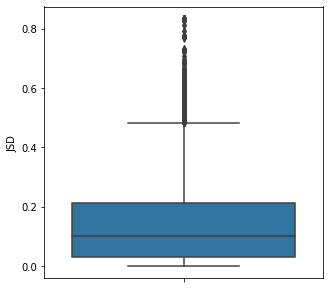

In [ ]:
mpl.rcParams["figure.figsize"] = (5, 5)
sns.boxplot(y="JSD", data=pd.DataFrame({'JSD':jsds_}))

## Part 4 - Deconvolute the ST spots

In [ ]:
#for mod in [ m for m in sys.modules if m.lstrip('_').startswith('AntiSplodge') or sys.modules[m] == None ]: del sys.modules[mod]
#import AntiSplodge as AS

# create dataloader so that we can predict the profiles of each spot in our ST dataset
dataset_spots = AS.SingleCellDataset(torch.from_numpy(np.array(ST.X)).float(), torch.from_numpy(np.array([0]*ST.n_obs)).float())
spots_loader = DataLoader(dataset=dataset_spots,
                      batch_size=50,
)

spot_preds = AS.predict(Exp, spots_loader) # predict spots

In [ ]:
# You should see all classes represented in here, if that doesn't happen, longer training is usually needed
np.mean(spot_preds, axis=0)

array([5.75722642e-02, 6.84831338e-03, 7.24636316e-02, 1.83002179e-04,
       1.76937710e-02, 7.21297474e-05, 5.11855069e-05, 2.35997681e-02,
       4.42252640e-05, 6.49160575e-05, 4.68118342e-05, 4.78129223e-04,
       1.31884779e-04, 3.61792845e-05, 1.94261956e-05, 1.21085664e-04,
       7.60163367e-03, 4.84962475e-05, 1.47192142e-04, 1.33771915e-04,
       1.61106494e-04, 4.09871922e-04, 1.09937660e-04, 6.94285263e-05,
       8.33556478e-05, 6.75627598e-05, 1.34064518e-02, 1.87022131e-04,
       5.25763207e-05, 1.40432341e-04, 4.36018221e-04, 2.02163734e-04,
       1.23950325e-01, 1.82200514e-04, 8.24528834e-05, 6.59929514e-01,
       3.65396590e-05, 2.17677653e-03, 1.19569144e-04, 5.23785269e-03,
       5.48379449e-03, 1.16884643e-04], dtype=float32)

In [ ]:
# combine observation dataframe with predictions
ST.obs = pd.concat((ST.obs, pd.DataFrame(spot_preds, columns=Exp.celltypes, index=ST.obs.index)), axis=1)
# extract observations 
pdf = ST.obs
# add more columns
pdf['celltype_max'] = pdf[Exp.celltypes].idxmax(axis=1)
pdf['celltype_maxval'] = pdf[Exp.celltypes].max(axis=1)

In [ ]:
ST.obs[Exp.celltypes]

,Astro,CA1-ProS,CA2,CA3,CR,CT SUB,Car3,DG,Endo,L2 IT ENTl,...,NP SUB,Oligo,Pvalb,SMC-Peri,SUB-ProS,Sncg,Sst,Sst Chodl,VLMC,Vip
AAACAAGTATCTCCCA-1,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.160331,0.0,0.0,0.839669,0.0,0.0,0.0,0.00000,0.000000,0.0
AAACAATCTACTAGCA-1,0.331087,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.668913,0.0,0.0,0.0,0.00000,0.000000,0.0
AAACACCAATAACTGC-1,0.392846,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.607154,0.0,0.0,0.0,0.00000,0.000000,0.0
AAACAGAGCGACTCCT-1,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.00000,0.000000,0.0
AAACCGGGTAGGTACC-1,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.00000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1,0.000000,0.080508,0.000000,0.0,0.141437,0.0,0.0,0.433758,0.0,0.0,...,0.000000,0.0,0.0,0.062350,0.0,0.0,0.0,0.08282,0.107725,0.0
TTGTTTCACATCCAGG-1,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.00000,0.000000,0.0
TTGTTTCATTAGTCTA-1,0.318661,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.681339,0.0,0.0,0.0,0.00000,0.000000,0.0
TTGTTTCCATACAACT-1,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.00000,0.000000,0.0


### Plot the highest values using scanpy

You should see a image very similar to that of the publication and the one listed below. 
Notice how the predicted spots are differentiable in the mouse hippocampus, this is exactly what, as the SC dataset is from this particular area. 
Additinoally, the markers are not as profound as in the paper, this would be better if you increased training time and the number of training/validation samples used. 

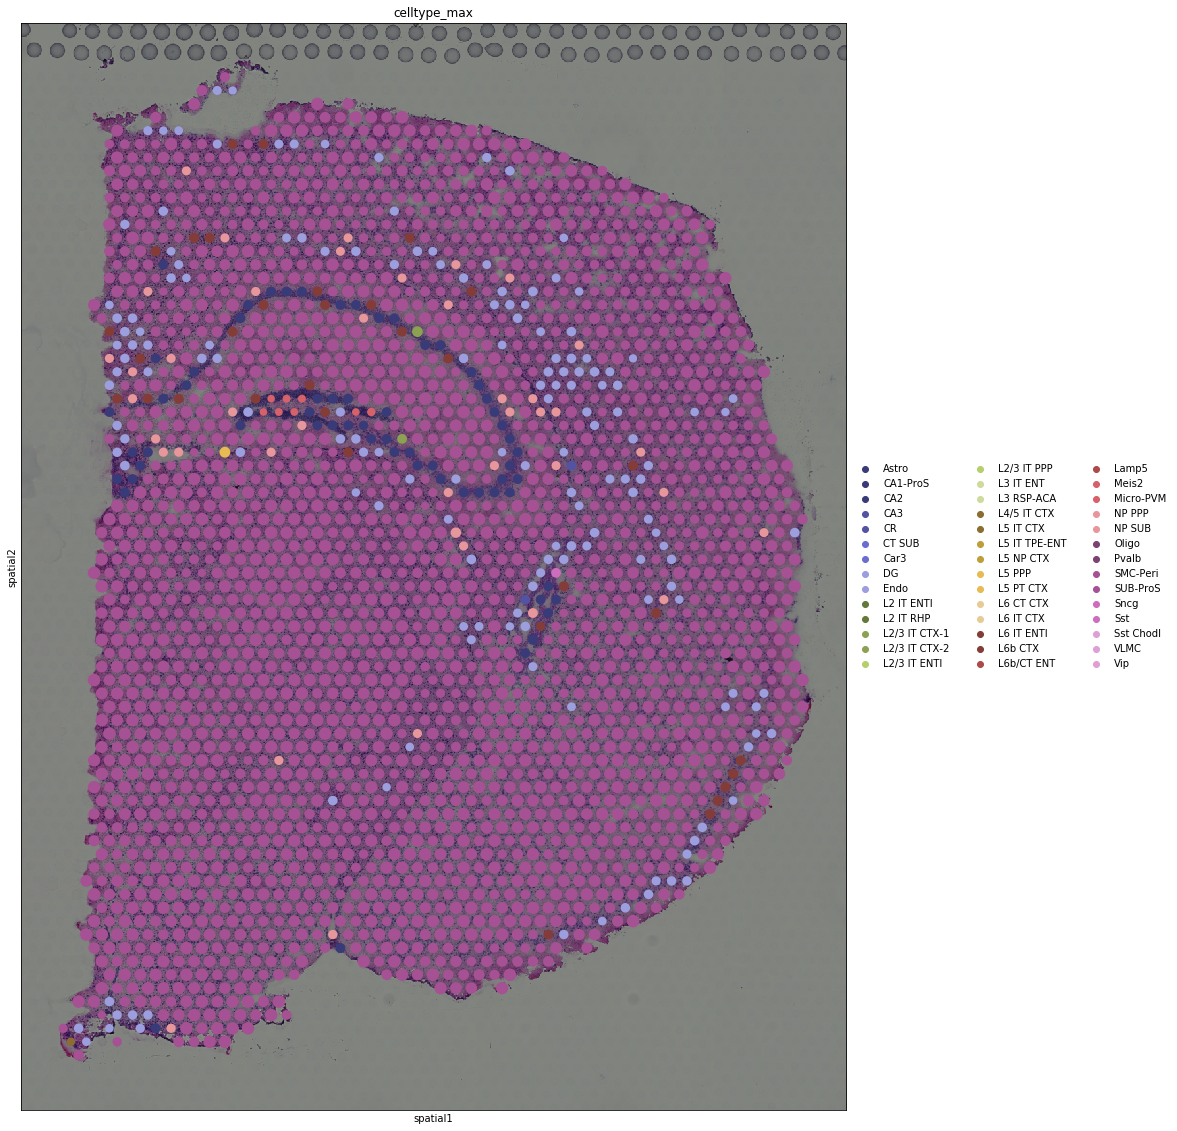

In [ ]:
# Get values for scaling of spots
val_=ST.obs['celltype_maxval']
scaled_val = ((val_-np.min(val_))/(np.max(val_)-np.min(val_)))/2+0.75

# plot each spot with the celltype color matching the celltype with the highest frequency for that respective spot
sc.pl.spatial(ST, color=["celltype_max"], size=scaled_val, palette='tab20b', save="MouseBrainPredictions.png")

In [ ]:
# In case you want to do your plots in another stat/plotting software (for example in R-studio)
ST.obs.to_csv("MouseBrain_predictions.csv") # save csv with predictions

img_ = Image.fromarray((ST.uns['spatial']['V1_Adult_Mouse_Brain']['images']['hires']* 255).astype(np.uint8))
img_.save("MouseBrain.png") # save image

## Closing remarks

This is all you should do in order to deconvolute spatial transcriptomics spots. Usually, playing around the with training time and the number of samples produces good results in a feasible amout of time. Especially selecting highly variable genes before finding the key marker genes, if the spatial transcriptomics spots are sparse (they usually are), it is beneficial to find the best genes in among the ones with differential power. 